In [376]:
# Packages import

import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import glob
import random
import pandas as pd
import pywt
from pywt import wavedec, dwt
from sporco.admm import tvl1
from itertools import product
import sporco
from sporco.admm import bpdn
import cv2
from skimage.measure import compare_ssim as ssim

In [377]:
# Data import for MovedObject Dataset

x_train = []
x_dev = []
x_test = []

for image_path in glob.glob("train_dataset/*.bmp"):
    image = misc.imread(image_path, mode = "L") # Reading in greyscale to speed up optimization
    image = misc.imresize(image, 0.45) # Resize image 
    image = image / 255 # Normalizing image 
    x_train.append(image)

for image_path in glob.glob("dev_dataset/*.bmp"):
    image = misc.imread(image_path, mode = "L") 
    image = misc.imresize(image, 0.45) 
    image = image / 255 
    x_dev.append(image)    

for image_path in glob.glob("test_dataset/*.bmp"):
    image = misc.imread(image_path, mode = "L")
    image = misc.imresize(image, 0.45)
    image = image / 255
    x_test.append(image)

x_train = np.stack(x_train)
x_dev = np.stack(x_dev)
x_test = np.stack(x_test)

# Data import for WavingTrees Dataset

x_train_2 = []
x_dev_2 = []
x_test_2 = []

for image_path in glob.glob("train_dataset_2/*.bmp"):
    image = misc.imread(image_path, mode = "L") # Reading in greyscale to speed up optimization
    image = misc.imresize(image, 0.4) # Resize image 
    image = image / 255 # Normalizing image 
    x_train_2.append(image)

for image_path in glob.glob("dev_dataset_2/*.bmp"):
    image = misc.imread(image_path, mode = "L") 
    image = misc.imresize(image, 0.4) 
    image = image / 255 
    x_dev_2.append(image)    

for image_path in glob.glob("test_dataset_2/*.bmp"):
    image = misc.imread(image_path, mode = "L")
    image = misc.imresize(image, 0.4)
    image = image / 255
    x_test_2.append(image)

x_train_2 = np.stack(x_train_2)
x_dev_2 = np.stack(x_dev_2)
x_test_2 = np.stack(x_test_2)


/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [378]:
class Object_Detector(object):
    """
    Implementation of the Compressive Sensing for Background Substraction algorithm reframed
    as an object detector class. All the hyperparameters were found using cross-validation. All
    the methods are commented.
    
    Arguments:
    im_w, im_h -- the image dimensions
    """

    def __init__(self, im_w, im_h, r=0.8, lmbda1=0.1, lmbda2=8e-1, alpha=0.01, 
                 gamma=0.9):
        """
        Initialization of the class.
        
        Arguments:
        r -- measurement rate (M / N)
        lambda 1 -- the BPDN L1 regularization hyperparameter
        lambda 2 -- the TV L1 regularization hyperparameter
        alpha -- the adaptation of the background constraint first learning rate
        gamma -- the adaptation of the background constraint second learning rate
        """
        
        self.im_w = im_w
        self.im_h = im_h
        self.N = int(self.im_w * self.im_h)
        self.r = r
        self.M = int(self.N * self.r)
        self.A = self.random_measurement_matrices(self.M, self.N)[1]
        self.phi = self.random_measurement_matrices(self.M, self.N)[0]
        self.lmbda1 = lmbda1
        self.lmbda2 = lmbda2
        self.alpha = alpha
        self.gamma = gamma
    
    @ staticmethod
    def wavelet_dec(sig, threshold=1):
        """
        Takes a signal as input, performs a single level Discrete Wavelet Transform of it and 
        sparsifies it with hard thresholding. Psi sparse basis in the article.

        Arguments:
        sig -- the signal to be sparsified (rows of the matrix Phi)
        threshold -- the data values where their absolute value is less than 
        the value param are replaced with substitute (default=0)

        Returns:
        sparse_sig -- signal expressed in a sparse haar wavelet basis 
        """

        coeffs = np.concatenate(dwt(sig, 'haar')) # Details and Approximation coefficients 
        sparse_sig = pywt.threshold(coeffs, threshold, 'hard') # Thresholding to sparsify

        return sparse_sig

    def random_measurement_matrices(self, M, N, rand_type = "gauss"):
        """
        Takes the measurement size M and the vector size of the image N and returns the 
        required matrices
        
        Arguments:
        M -- measurement size
        N -- the total size of the image (nx x ny)
        rand_type -- type of random distribution for the measurement matrix

        Returns:
        A -- matrix of dimension (M x N), corresponds to Phi * Psi in the article
        phi -- the measurement matrix
        """
        
        np.random.seed(10) # Setting seed for reproductibility
        if rand_type == "student":
            phi = np.random.standard_t(power, size=(M, N))
        else:
            phi = np.random.randn(M, N)
            
        A = np.apply_along_axis(wavelet_dec, axis=1, arr=phi) # Equivalent to the Phi * Psi product
            
        return phi, A
        
    
    def compressive_measurements(self, x):
        """
        Takes an image and the compression rate as argument, returns a dictionnary

        Arguments:
        x -- the original image

        Returns: 
        y -- vector of dimension (M (= r * N) x 1)
        
        """
        x = x.reshape(1, -1).T # Reshape the image to be a (N x 1) vector
        y =  np.dot(self.A, x) # Compressive samples generation 

        return y
    
    def signal_reconstruction(self, y):
        """
        Signal recovery using the Basis Pursuit Denoising (BPDN) and the L1
        Total Variation (TV) denoising algorithm from the SPORCO package

        Arguments:
        y -- the measurement vector of size (M x 1)

        Returns:
        x_hat -- the recovered signal from BPDN optimization (N x 1) 
        x_hat_rshp -- the reshaped recovered signal of size (nx x ny)
        x_hat_tv -- the denoised recovered signal of size (nx x ny)  
        """
        
        # Run BPDN optimisation
        opt1 = bpdn.BPDN.Options()
        x = bpdn.BPDN(self.A, y, self.lmbda1, opt1)
        x_hat = x.solve()
        x_hat_rshp = x_hat.reshape(self.im_w, self.im_h)
        opt2 = tvl1.TVL1Denoise.Options()

        # Initialise and run TVL1Denoise object
        b1 = tvl1.TVL1Denoise(x_hat_rshp, self.lmbda2, opt2)
        x_hat_tv = b1.solve()

        return x_hat, x_hat_rshp, x_hat_tv
    
    def fit(self, x_train):
        
        """
        Fit the model to the training background data using maximum likelihood estimation.
        Corresponds to the section 3.2 and 3.3 of the article. 
        
        Arguments:
        x_train -- the compressive measurements of the background training data
        
        Returns:
        x_b -- the mean of the training background image
        y_b -- the mean of the correspond

        """
        
        # Maximum Likelihood Estimation
        x_b = np.mean(x_train, axis=0)
        y_b = self.compressive_measurements(x_b)
        y_train = [self.compressive_measurements(x) for x in x_train]
        l = [np.log(np.sum((yi - y_b) ** 2)) for yi in y_train]
        mu_bg = np.mean(l)
        sigma_bg = (1 / (len(l) - 1)) * np.sum((l - mu_bg) ** 2)
        model = {"x_b" :x_b, "y_b" : y_b, "mu_bg" : mu_bg, "sigma_bg" : sigma_bg}
        
        return model

    @ staticmethod
    def mse(imageA, imageB):
        """
        Returns the Mean Squared Error of two images pixelwise
        """

        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])

        return err
    
    @ staticmethod
    def compare_images(imageA, imageB, title):
        """
        Compare two images using the MSE and the more advanced 
        skimage structural similarity index. 
        """
    
        m = mse(imageA, imageB) # between 0 and +infty (0 best)
        s = ssim(imageA, imageB) # between -1 and 1 (1 best)

        # setup the figure
        fig = plt.figure()
        plt.title(title)
        plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
        plt.axis("off")

        # show first image
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(imageA)
        plt.axis("off")

        # show the second image
        ax = fig.add_subplot(1, 2, 2)
        plt.imshow(imageB)
        plt.axis("off")

        # show the images
        plt.show()

    def predict(self, x_test, model, rec=False, backup=0):
        
        mu_bg = model["mu_bg"]
        sigma_bg = model["sigma_bg"]
        y_b = model["y_b"]
        x_b = model["x_b"]
        xb_hat, xb_hat_rshp, xb_hat_tv = self.signal_reconstruction(y_b)
        
        # Testing if the test image has a new object
        y_test_to_date = []
        for i, xtest in enumerate(x_test):
            y_t = self.compressive_measurements(xtest)
            y_test_to_date.append(y_t)
            if i > 5:
                del y_test_to_date[0]
            y_d = y_t - y_b
            dist = np.log(np.sum(y_d ** 2))
            d = np.abs(dist - mu_bg)
            if  d >= c * np.sqrt(sigma_bg):
                print("Object Detected!") 
            xd_hat, xd_hat_rshp, xd_hat_tv = self.signal_reconstruction(y_d)
            y_d_hat = np.dot(self.A, xd_hat)
            
            if backup == 1:
                y_b_new = self.background_update_1(y_b, y_t, y_d_hat)
                y_b = y_b_new
                xb_hat, xb_hat_rshp, xb_hat_tv = self.signal_reconstruction(y_b)
                
            if backup == 2:
                y_b_new = self.background_update_2(y_b, y_t, y_test_to_date)
                y_b = y_b_new
                xb_hat, xb_hat_rshp, xb_hat_tv = self.signal_reconstruction(y_b)
                
            if rec:
                fig = plt.figure(figsize=(8, 8))
                ax1 = plt.subplot(222)
                ax1.set_title("Background Image")
                ax1.imshow(xb_hat_tv)
                ax1.axis("off")
                ax2 = plt.subplot(223)
                ax2.set_title("Test Image")
                ax2.imshow(xtest)
                ax2.axis("off")
                ax3 = plt.subplot(224)
                ax3.set_title("Difference Image")
                ax3.imshow(xd_hat_tv)
                ax3.axis("off")
                plt.show()

    def background_update_1(self, y_b, y_t, y_d_hat):
        y_b_new = self.alpha * (y_t - y_d_hat) + (1 - self.alpha) * y_b
        return y_b_new
    
    def background_update_2(self, y_b, y_t, y_test_to_date):
        y_ma = np.mean(y_test_to_date, axis=0)
        xma_hat, xma_hat_rshp, xma_hat_tv = self.signal_reconstruction(y_ma)
        y_ma_new = self.gamma * y_t + (1 - self.gamma) * y_ma
        y_e_hat = np.dot(self.A, xma_hat)        
        y_b_new = self.alpha * (y_t - y_e_hat) + (1 - self.alpha) * y_b
        return y_b_new


In [ ]:
cls = Object_Detector(54, 72, r=0.4)
model = cls.fit(x_train)


6.596875974954273 0.0030830820620576663
Object Detected!


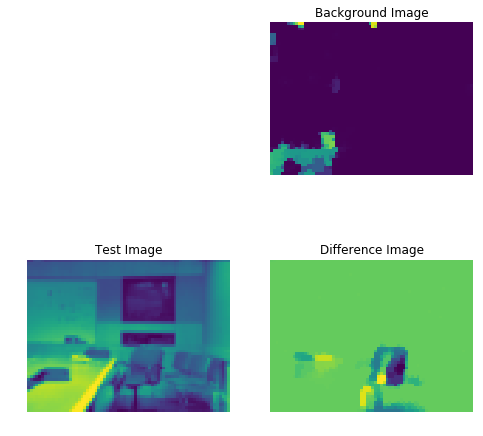

6.892305627536098 0.0030830820620576663
Object Detected!


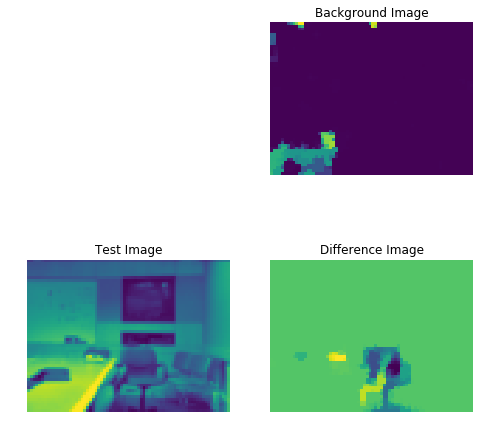

6.8792912007294635 0.0030830820620576663
Object Detected!


KeyboardInterrupt: 

In [362]:
cls.predict(x_test, model, rec=True, backup=2)

0.42940065484143375 0.1847843264890554


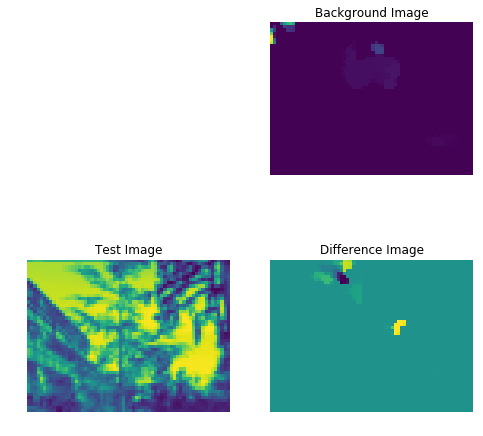

0.043875609641421676 0.1847843264890554


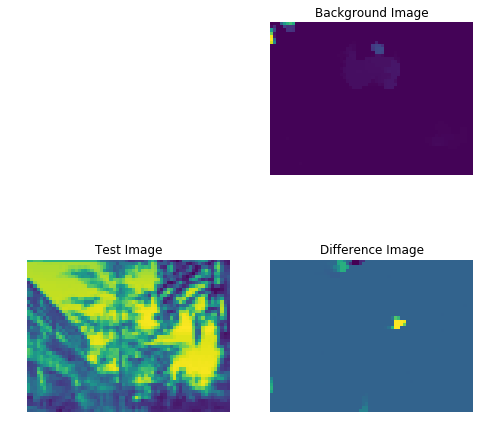

0.7788543632245037 0.1847843264890554


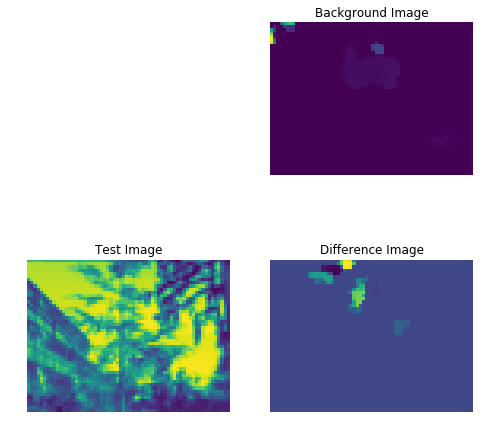

0.31956631435009264 0.1847843264890554


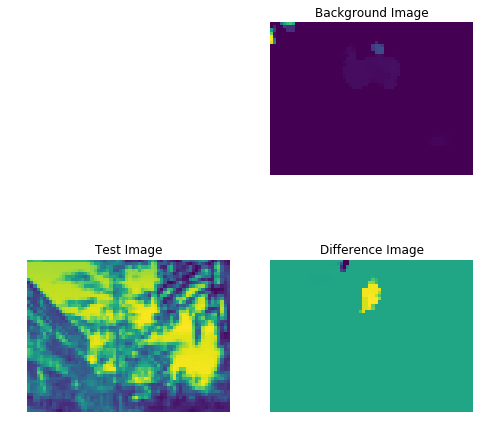

0.8527039635971647 0.1847843264890554


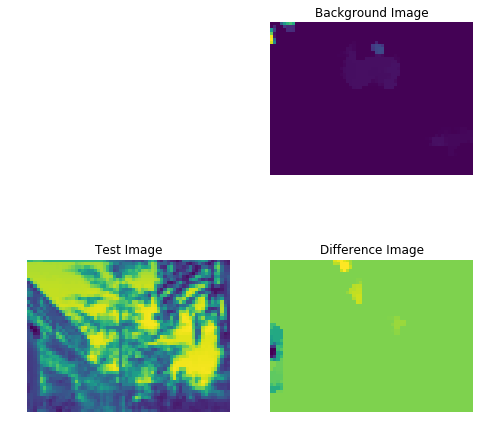

1.0636827772162167 0.1847843264890554


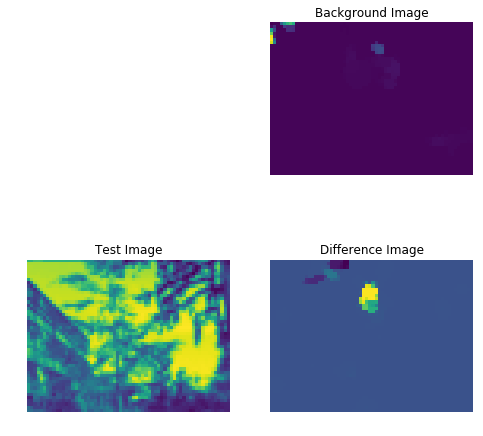

0.43473980170530524 0.1847843264890554


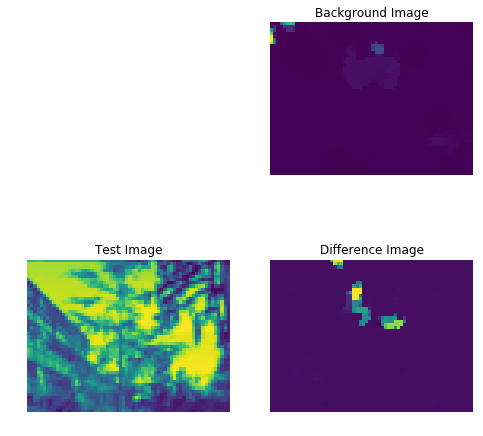

1.0329044076345326 0.1847843264890554


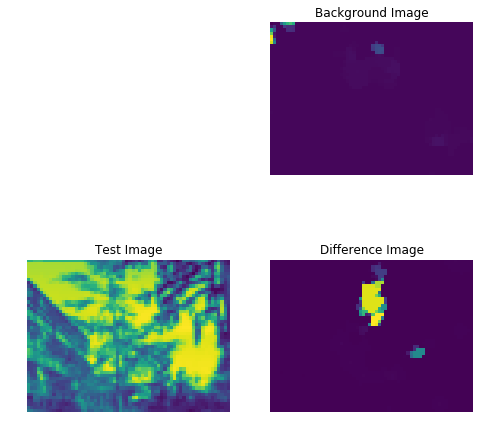

0.6054073265597157 0.1847843264890554


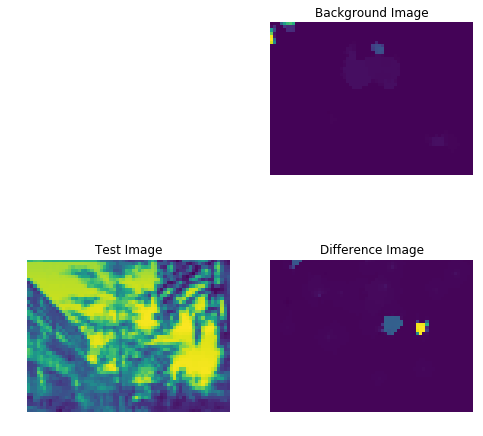

1.3887958564656238 0.1847843264890554


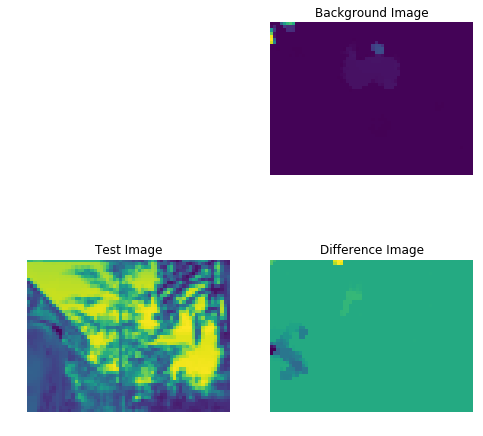

1.1459716145640861 0.1847843264890554


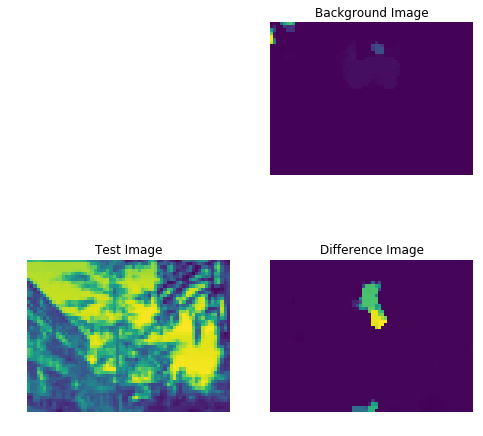

1.3358804660959702 0.1847843264890554


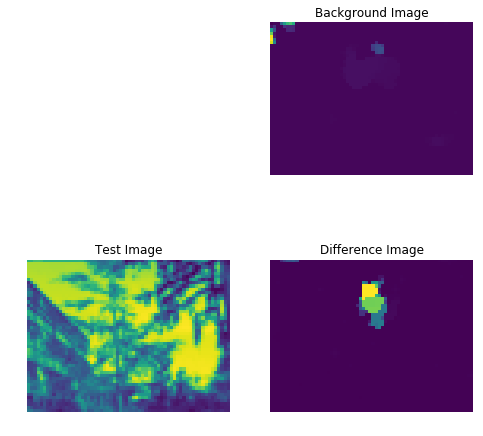

2.916961190842388 0.1847843264890554


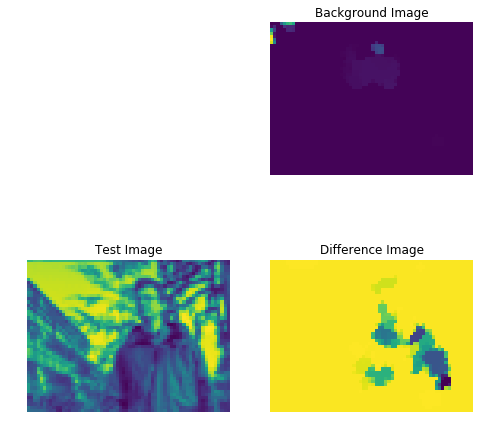

2.8761448767545748 0.1847843264890554


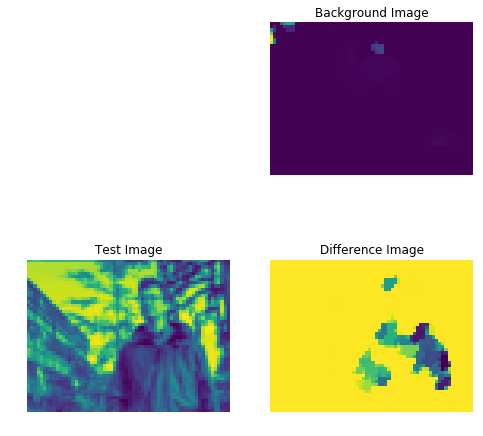

1.3710822867122836 0.1847843264890554


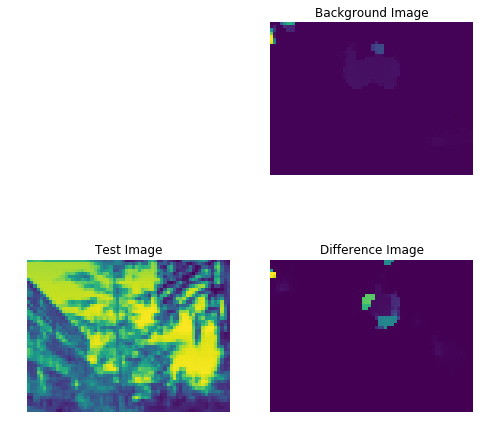

1.5788229368884128 0.1847843264890554


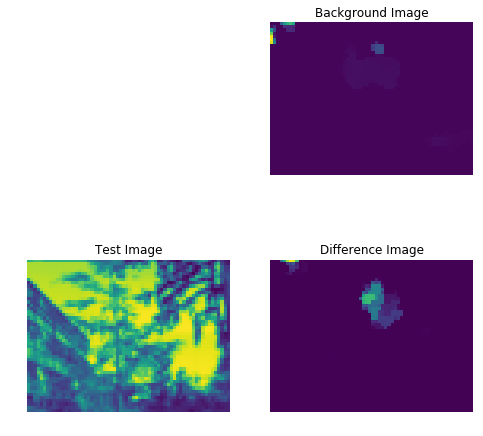

1.4899858082652493 0.1847843264890554


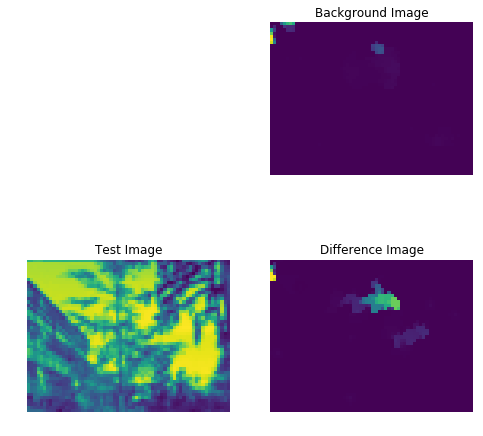

1.5701247507011562 0.1847843264890554


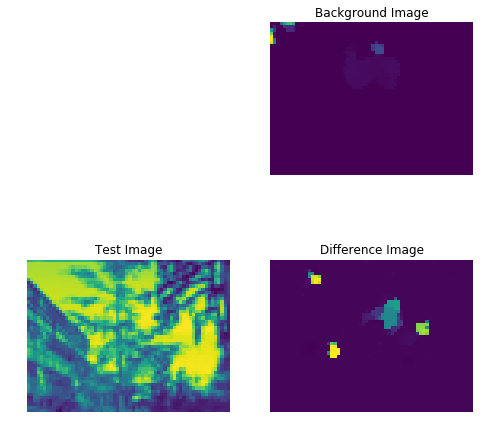

1.8183152410026207 0.1847843264890554


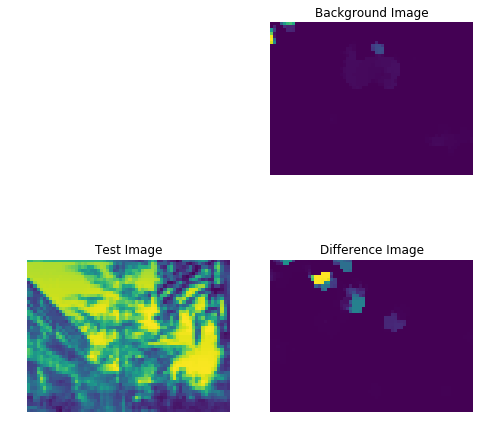

1.8869073057894816 0.1847843264890554


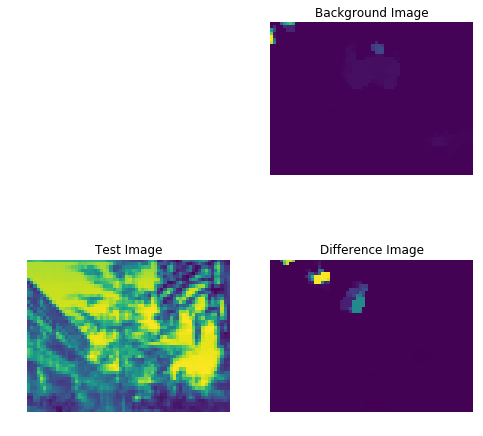

2.7661603261791416 0.1847843264890554


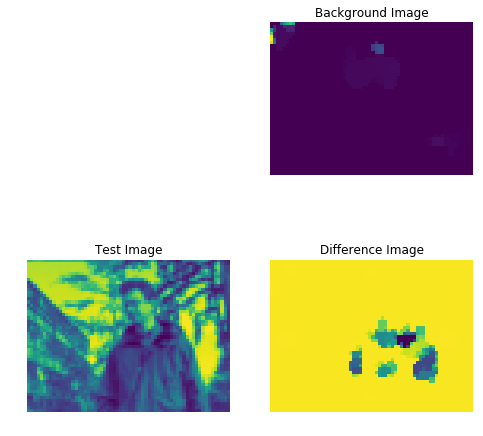

1.946374870943366 0.1847843264890554


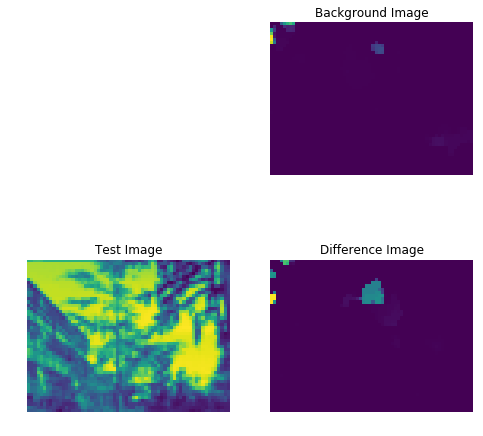

2.154845934982717 0.1847843264890554


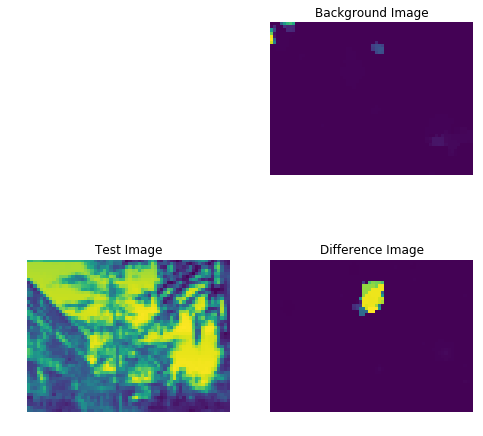

2.847504433920424 0.1847843264890554


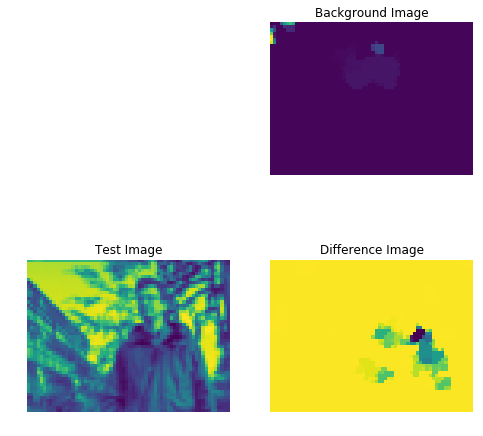

2.2842840004193636 0.1847843264890554


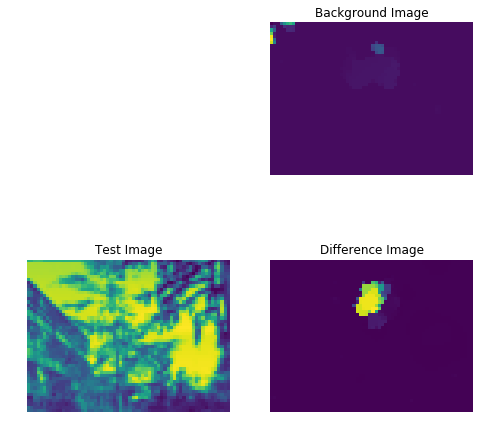

2.9223459771337605 0.1847843264890554


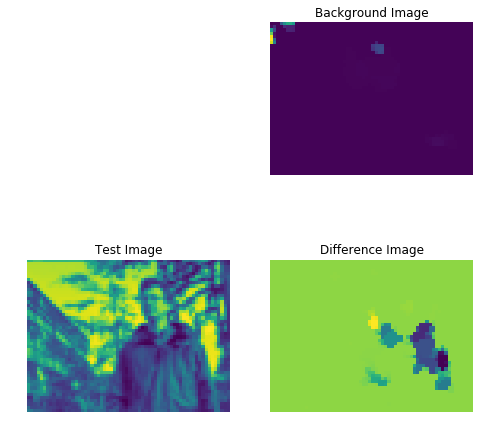

2.2719563166292236 0.1847843264890554


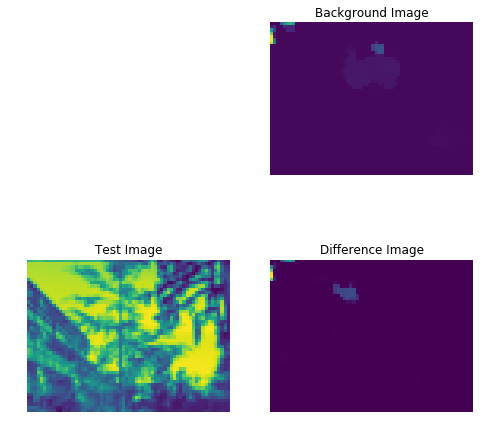

2.891400353446553 0.1847843264890554


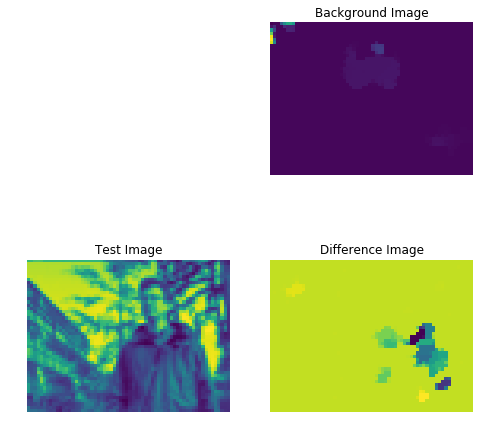

2.394323079449462 0.1847843264890554


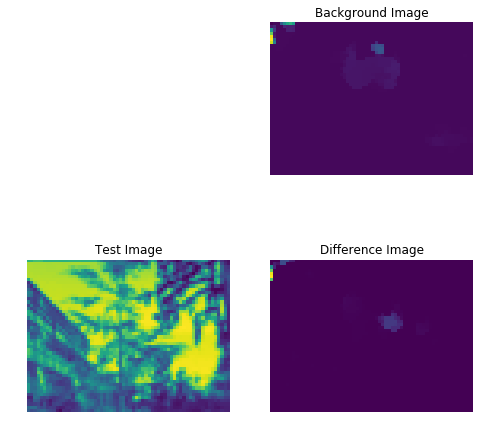

2.8290635870038514 0.1847843264890554


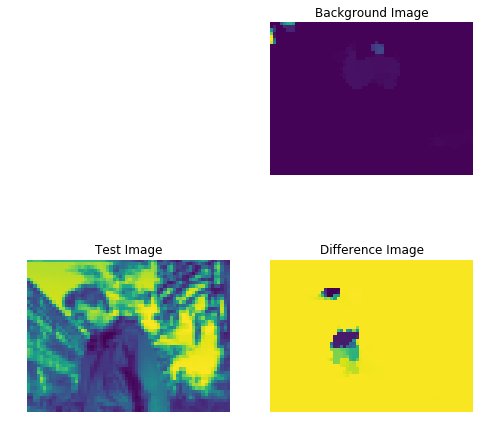

2.5070716611872523 0.1847843264890554


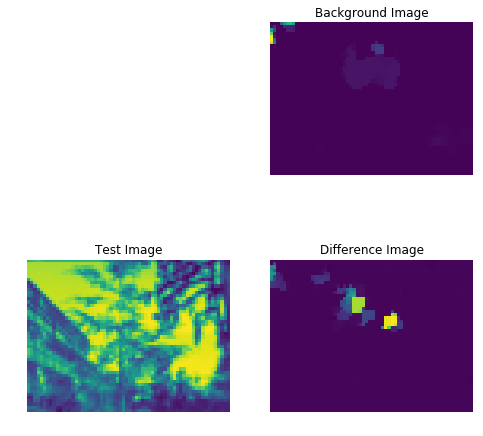

2.5582272756831284 0.1847843264890554


KeyboardInterrupt: 

In [363]:
cls = Object_Detector(48, 64, r=0.4)
model = cls.fit(x_train_2)
cls.predict(x_test_2, model, rec=True, backup=2)
